# Imports

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Data

In [2]:
from IPython.display import clear_output

from djimaging.user.alpha.utils import database

# Choose indicator by uncommenting one of the following lines
indicator = 'calcium'
# indicator = 'glutamate'

database.connect_dj(indicator=indicator)
clear_output()

In [3]:
exp_tab = database.get_experiment_tab()
morph_tab = database.get_morph_tab()

rf_tab = database.get_rf_tab(quality_filter=True, rf_quality_filter=True)
field_rf_tab = database.get_rf_tab(roi_kind='field', rf_quality_filter=True, quality_filter=False)

roi_pos_tab = database.get_roi_pos_tab()
paths_tab = database.get_paths_tab()

# Plot

In [4]:
from alphaanalysis import plot as plota

plota.set_default_params(kind='paper')

FIGURE_FOLDER = './figures/'

## Correct ROI level

In [5]:
df_field_rfs, field_avg_dx, field_avg_dy = database.get_field_avg_offset(rf_quality_filter=True)

In [6]:
df_field_rfs, field_avg_dx, field_avg_dy = database.get_field_avg_offset(rf_quality_filter=True)

df_rois = (
    rf_tab.proj('rf_dx_um', 'rf_dy_um', 'rf_d_um') * 
    roi_pos_tab.proj('roi_pos_xyz', 'roi_pos_xyz_rel_to_soma', 'roi_dx_um', 'roi_dy_um', 'roi_d_um', 'field_path_pos_x', 'field_path_pos_y', 'd_dist_to_soma')
).fetch(format='frame').reset_index()

print(f"Offset between ROI RF and Field Centers: {df_rois['rf_d_um'].mean():.0f} +/- {df_rois['rf_d_um'].std():.0f}")

if indicator == 'glutamate':    # Stimulus was flipped on this setup, so we need to correct for this
    df_rois['rf_dy_um'] = -df_rois['rf_dy_um']
    df_field_rfs['field_rf_dy_um'] = -df_field_rfs['field_rf_dy_um']
    field_avg_dy = -field_avg_dy

df_rois['roi_pos_x_wrt_soma'] = df_rois['roi_pos_xyz_rel_to_soma'].apply(lambda x: x[0])
df_rois['roi_pos_y_wrt_soma'] = df_rois['roi_pos_xyz_rel_to_soma'].apply(lambda x: x[1])
df_rois = df_rois.drop('roi_pos_xyz_rel_to_soma', axis=1)

df_rois['roi_pos_x'] = df_rois['roi_pos_xyz'].apply(lambda x: x[0])
df_rois['roi_pos_y'] = df_rois['roi_pos_xyz'].apply(lambda x: x[1])
df_rois = df_rois.drop('roi_pos_xyz', axis=1)

id_cols = [col for col in df_rois.columns if col.endswith('_id') and col != 'roi_id']
for col in id_cols:
    assert df_rois[col].nunique() == 1

df_rois = df_rois.drop(id_cols + ['roi_pos_params_hash', 'stim_name', 'cond1', 'experimenter'], axis=1)
df_rois['date'] = df_rois['date'].astype(str)
df_rois.set_index(['date', 'exp_num', 'field', 'roi_id'], inplace=True)

df_rois['rf_x_um'] = df_rois['field_path_pos_x'] + df_rois['rf_dx_um']
df_rois['rf_y_um'] = df_rois['field_path_pos_y'] + df_rois['rf_dy_um']

df_rois['rf_dx_wrt_field_rf_um'] = df_rois['rf_dx_um'] - df_field_rfs['field_rf_dx_um']
df_rois['rf_dy_wrt_field_rf_um'] = df_rois['rf_dy_um'] - df_field_rfs['field_rf_dy_um']
df_rois['rf_d_wrt_field_rf_um'] = (df_rois['rf_dx_wrt_field_rf_um']**2 + df_rois['rf_dy_wrt_field_rf_um']**2)**0.5

df_rois['rf_x_um_corrected_field_rf'] = df_rois['rf_x_um'] - df_field_rfs['field_rf_dx_um']
df_rois['rf_y_um_corrected_field_rf'] = df_rois['rf_y_um'] - df_field_rfs['field_rf_dy_um']

df_rois['rf_x_um_corrected_field_rf_avg'] = (df_rois['rf_x_um'] - field_avg_dx)
df_rois['rf_y_um_corrected_field_rf_avg'] = (df_rois['rf_y_um'] - field_avg_dy)

keep_idx = df_rois['rf_dx_wrt_field_rf_um'].notnull()
n_remove = np.sum(~keep_idx)
print(f'Removing {n_remove} ROIs because there is no Field RF')
print(f"Offset between ROI RF and Field RFs: {df_rois['rf_d_wrt_field_rf_um'].mean():.0f} +/- {df_rois['rf_d_wrt_field_rf_um'].std():.0f}")

Offset between ROI RF and Field Centers: 36 +/- 21
Removing 3 ROIs because there is no Field RF
Offset between ROI RF and Field RFs: 14 +/- 12


### On morph

In [7]:
exp_keys = (exp_tab & morph_tab.proj()).proj().fetch(as_dict=True)

In [8]:
exp_keys

[{'experimenter': 'Ran', 'date': datetime.date(2018, 6, 10), 'exp_num': 1},
 {'experimenter': 'Ran', 'date': datetime.date(2020, 5, 10), 'exp_num': 1},
 {'experimenter': 'Ran', 'date': datetime.date(2020, 5, 10), 'exp_num': 2},
 {'experimenter': 'Ran', 'date': datetime.date(2020, 5, 11), 'exp_num': 1},
 {'experimenter': 'Ran', 'date': datetime.date(2020, 5, 11), 'exp_num': 2},
 {'experimenter': 'Ran', 'date': datetime.date(2020, 6, 7), 'exp_num': 1},
 {'experimenter': 'Ran', 'date': datetime.date(2020, 6, 8), 'exp_num': 1},
 {'experimenter': 'Ran', 'date': datetime.date(2020, 6, 8), 'exp_num': 2},
 {'experimenter': 'Ran', 'date': datetime.date(2020, 6, 21), 'exp_num': 1},
 {'experimenter': 'Ran', 'date': datetime.date(2020, 7, 5), 'exp_num': 2},
 {'experimenter': 'Ran', 'date': datetime.date(2020, 7, 8), 'exp_num': 1},
 {'experimenter': 'Ran', 'date': datetime.date(2020, 7, 13), 'exp_num': 1},
 {'experimenter': 'Ran', 'date': datetime.date(2020, 8, 23), 'exp_num': 1},
 {'experimenter':

In [9]:
len(exp_keys)

17

In [10]:
def get_df_rois_exp(exp_key):
    return df_rois.loc[(str(exp_key['date']), exp_key['exp_num'])]

In [11]:
def plot_morph_and_rf_offset_roi_level(ax, exp_key, dmax=100, offset_correction='none'):
    df_paths = pd.DataFrame((morph_tab & exp_key).fetch1('df_paths'))
    plota.plot_paths(ax=ax, paths=df_paths.path, lw=0.3, clip_on=False)
    ax.set_aspect('equal', 'box')

    # Get ROI data
    df_rois_exp = get_df_rois_exp(exp_key)

    roi_x, roi_y = df_rois_exp['roi_pos_x'], df_rois_exp['roi_pos_y']

    if offset_correction == 'none':
        rf_x, rf_y = df_rois_exp['rf_x_um'], df_rois_exp['rf_y_um']
    elif offset_correction == 'field_rf':
        rf_x, rf_y = df_rois_exp['rf_x_um_corrected_field_rf'], df_rois_exp['rf_y_um_corrected_field_rf']
    elif offset_correction == 'field_rf_avg':
        rf_x, rf_y = df_rois_exp['rf_x_um_corrected_field_rf_avg'], df_rois_exp['rf_y_um_corrected_field_rf_avg']
    else:
        raise NotImplementedError(offset_correction)

    rf_dx = rf_x - roi_x
    rf_dy = rf_y - roi_y

    # Compute distances
    rf_d = (rf_dx ** 2 + rf_dy ** 2) ** 0.5
    print(f"{rf_d.max():.1f}", end='\t')
    palette = sns.color_palette("plasma", as_cmap=True)

    # Plot ROI and RF centers (the latter might be corrected)
    for i, (rf_x_i, rf_y_i, roi_x_i, roi_y_i, rf_d_i) in enumerate(zip(rf_x, rf_y, roi_x, roi_y, rf_d)):
        c = palette(rf_d_i / dmax)
        ax.plot(rf_x_i, rf_y_i, '.', label='rf', c=c, ms=1)
        ax.plot([roi_x_i, rf_x_i], [roi_y_i, rf_y_i], '-', c=c, alpha=1, lw=0.5)

    return rf_d.max()

77.7	46.5	72.8	

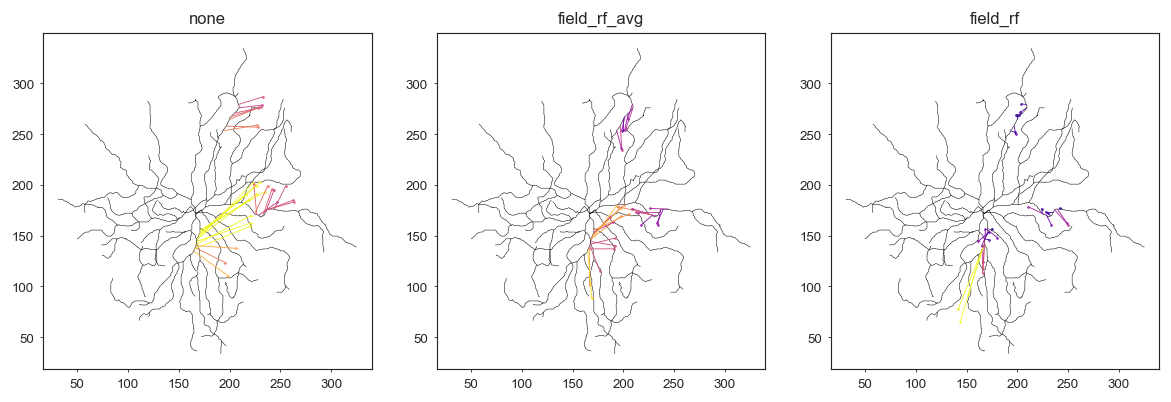

In [12]:
exp_key = exp_keys[0]

fig, axs = plt.subplots(1, 3, figsize=(12, 6))

for ax, offset_correction in zip(axs, ['none', 'field_rf_avg', 'field_rf']):
    plot_morph_and_rf_offset_roi_level(ax, exp_key, offset_correction=offset_correction, dmax=50)
    ax.set_title(offset_correction)

77.7	52.6	125.5	58.0	47.2	57.8	56.0	116.7	96.9	95.7	60.4	100.0	77.2	66.3	54.6	104.0	87.9	

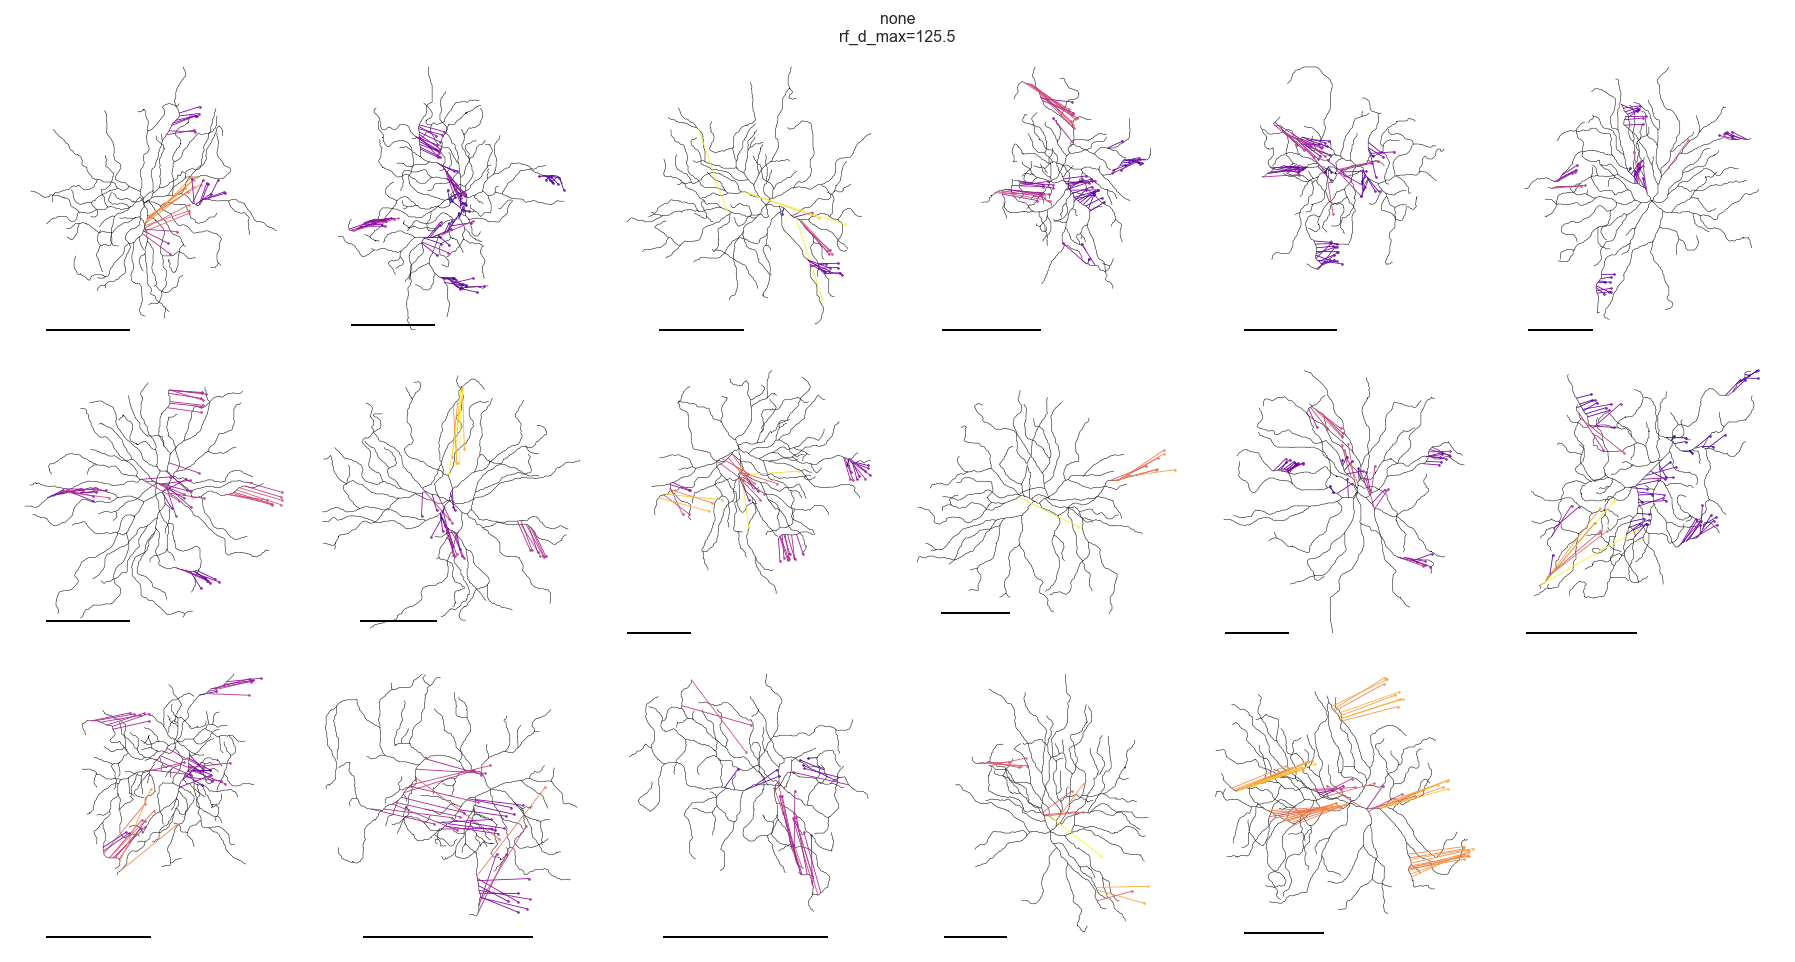

46.5	37.7	92.0	45.9	56.2	49.8	34.5	93.8	76.0	74.8	63.1	87.5	73.5	53.8	66.4	84.3	112.5	

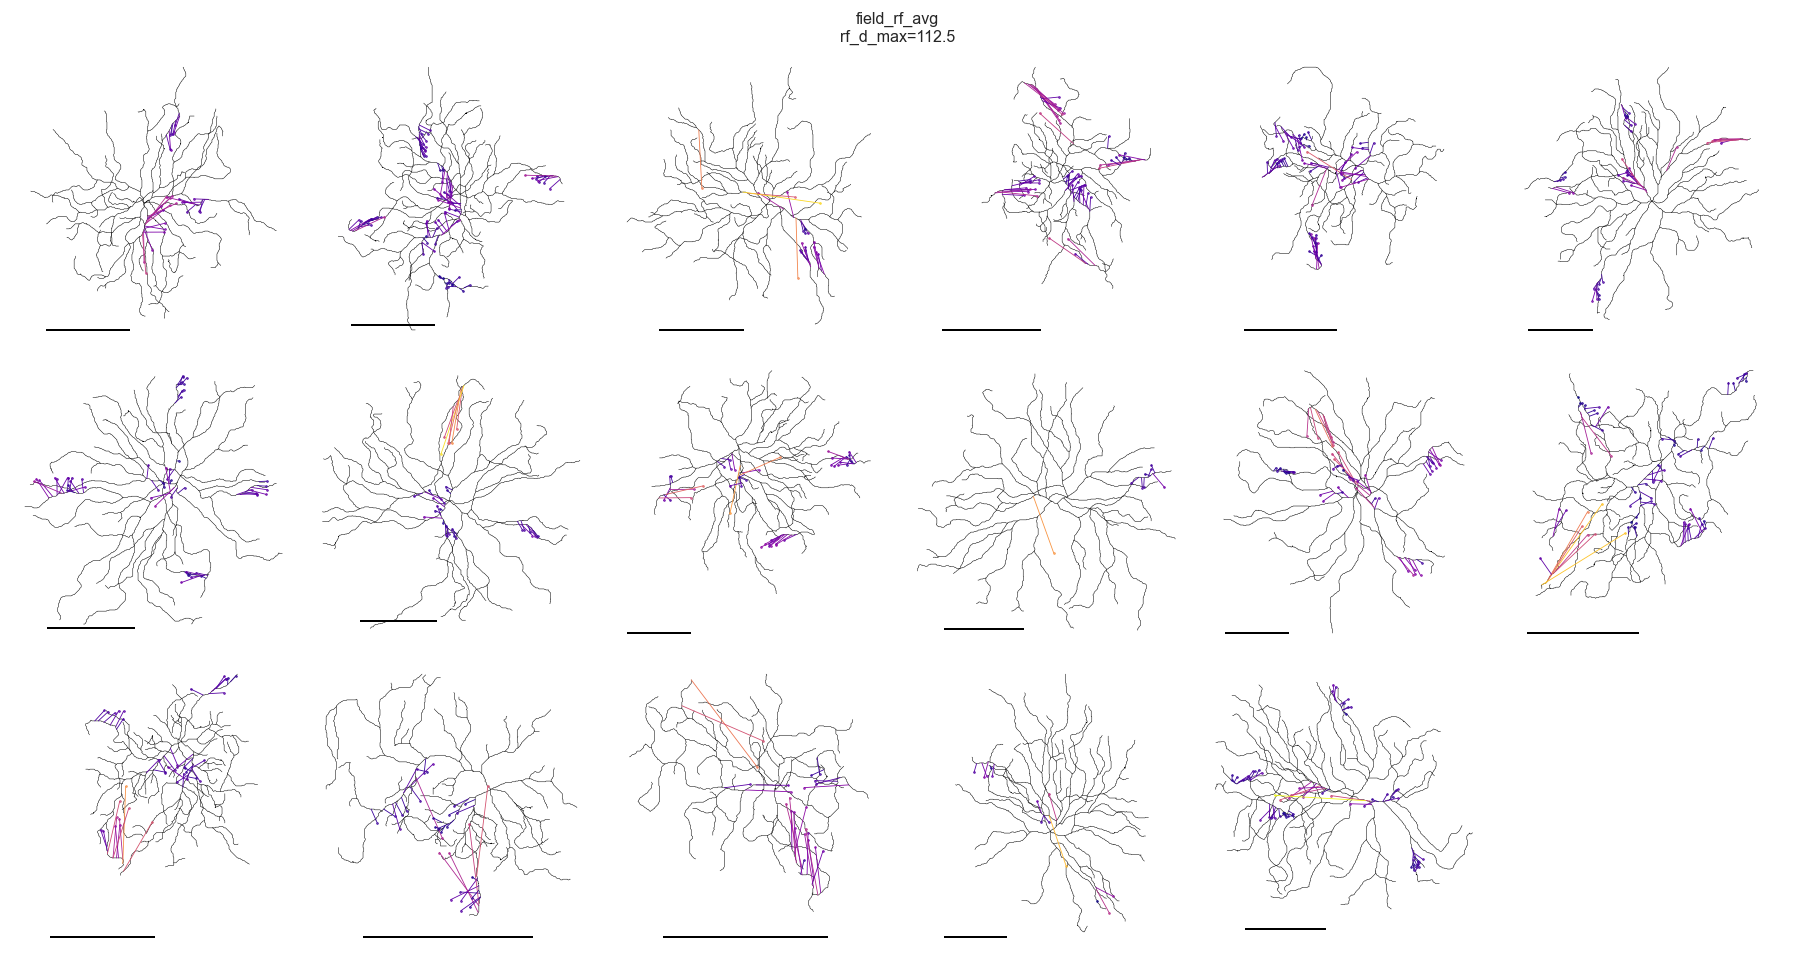

72.8	26.6	83.4	62.5	56.2	32.8	34.8	35.2	83.0	22.6	37.5	61.5	35.4	45.0	18.8	95.2	79.7	

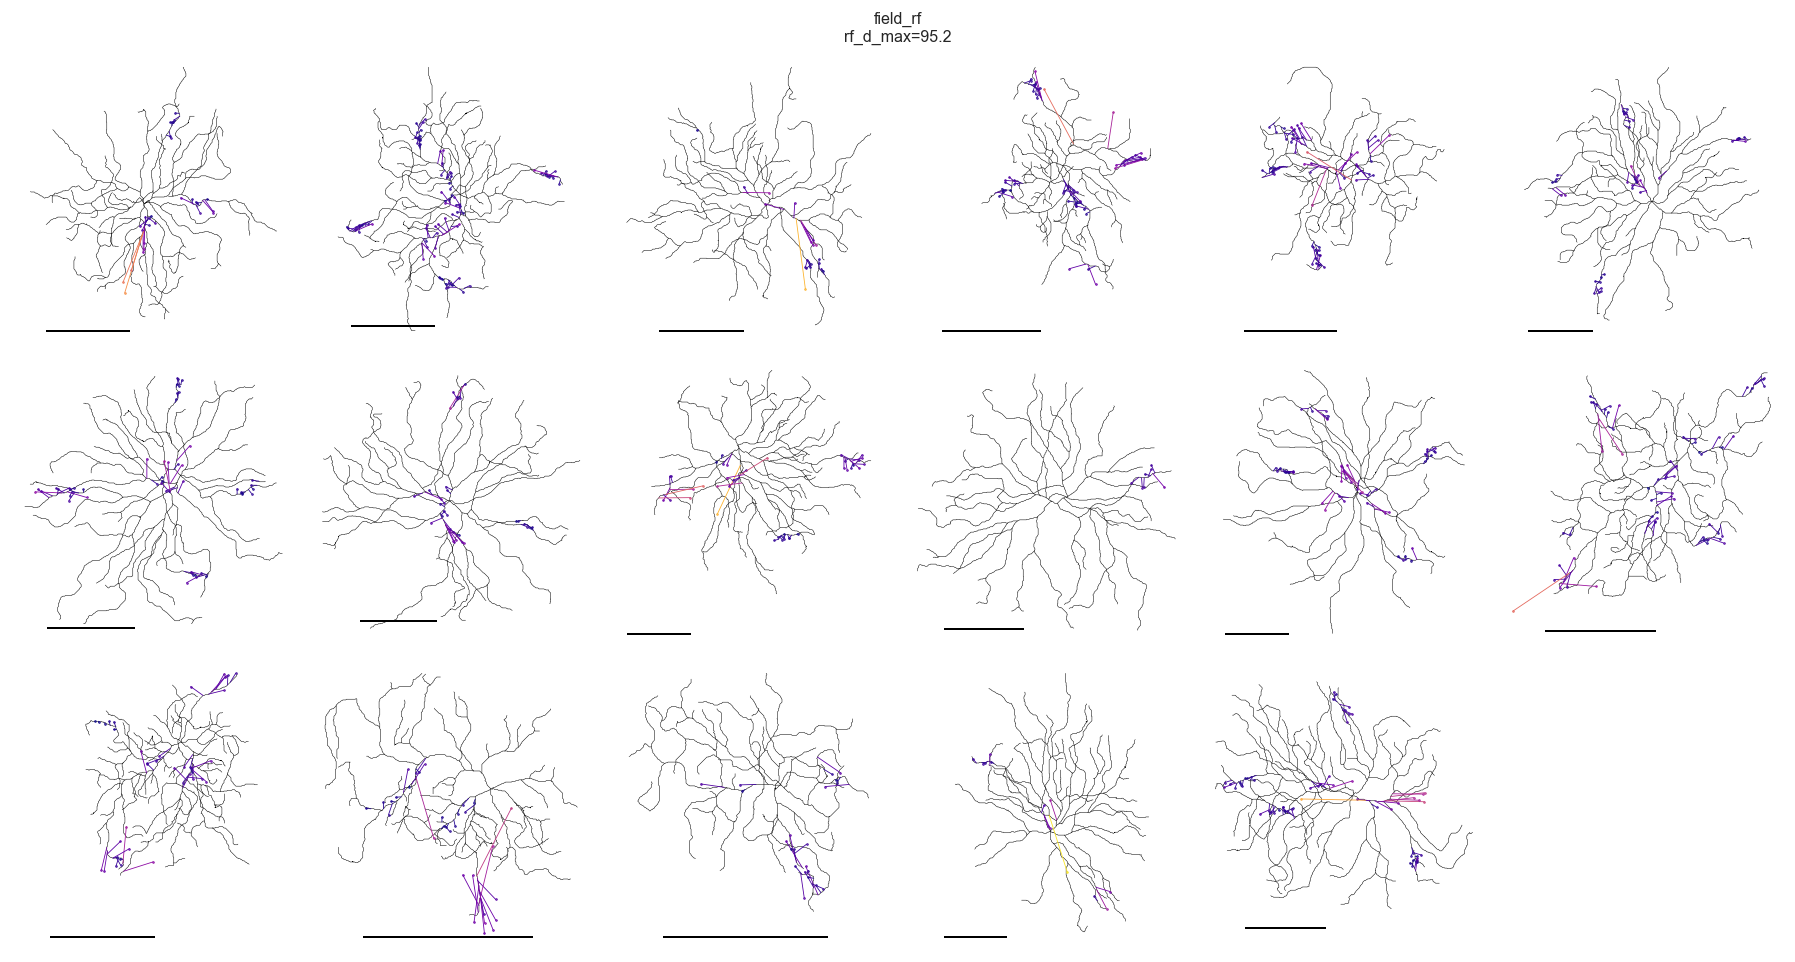

In [13]:
for offset_correction in ['none', 'field_rf_avg', 'field_rf']:
    nrows = int(np.ceil(len(exp_keys) / 6))
    fig, axs = plt.subplots(nrows, 6, figsize=(15, nrows*2.7))
    axs = axs.flatten()

    rf_ds = []

    for ii, exp_key in enumerate(exp_keys):
        ax = axs[ii]
        rf_ds.append(
            plot_morph_and_rf_offset_roi_level(ax, exp_key, dmax=100, offset_correction=offset_correction)
        )
        plota.plot_scale_bar(ax, x0=50, y0=20, text='', size=100)
        ax.axis('off')

    for ax in axs[ii:]:
        ax.axis('off')

    fig.suptitle(offset_correction + '\n' + f'rf_d_max={np.max(rf_ds):.1f}')
    plt.tight_layout()
    plt.show()

## ROI pos vs RF pos wrt. to field

In [14]:
import pingouin as pg

In [15]:
def plot_roi_level(axs, method='pearson'):
    for i, p in enumerate(['x', 'y']):
        ax = axs[i]

        col_x = f'roi_d{p}_um'
        col_y = f'rf_d{p}_wrt_field_rf_um'

        not_null = df_rois[col_x].notnull() &  df_rois[col_y].notnull()
        test = pg.corr(df_rois[col_x][not_null], df_rois[col_y][not_null], method=method)
        
        display(test)
        r_stat = test.loc[method, 'r']

        sns.regplot(ax=ax, data=df_rois, x=col_x, y=col_y,
                    scatter_kws=dict(s=1, alpha=0.5, fc='C0', ec='none'), line_kws=dict(color='k'),
                    ci=None)

        #ax.set_aspect('equal', 'datalim')
        vmin = np.max([df_rois[col_x].min(), df_rois[col_y].min()])
        vmax = np.min([df_rois[col_x].max(), df_rois[col_y].max()])

        ax.axhline(0, c='gray', alpha=0.7, zorder=-10, ls='--')
        ax.axvline(0, c='gray', alpha=0.7, zorder=-10, ls='--')
        ax.axline([vmin * 1.3, vmin * 1.3], [vmax * 1.3, vmax * 1.3], c='gray', alpha=0.7, zorder=-10, ls='--',
                  clip_on=True)

        ax.set(title=f'r²={r_stat ** 2:.2f}',
               xlabel=rf'$\Delta${p} ' + r'(ROI, Field)' + '\n[µm]',
               ylabel=rf'$\Delta${p} ' + r'(RF$_\mathrm{ROI}$, RF$_\mathrm{Field}$)' + '\n[µm]')

    for ax in axs:
        ax.set(xticks=(-25, 0, 25), yticks=(-50, 0, 50))

,n,r,CI95%,p-val,BF10,power
pearson,687,0.521304,"[0.46, 0.57]",3.932625e-49,5.164e+45,1.0


,n,r,CI95%,p-val,BF10,power
pearson,687,0.374254,"[0.31, 0.44]",2.892559e-24,1.148e+21,1.0


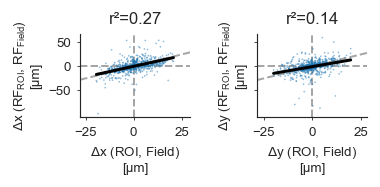

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(3.2, 1.6), sharey='row')
sns.despine()
plot_roi_level(axs)
plt.tight_layout(w_pad=2)
#fig.savefig(os.path.join(FIGURE_FOLDER, f'roi_rf_pos_vs_rel_roi_pos_{indicator}.pdf'), bbox_inches='tight')

## ROI-RF-distance vs soma distance

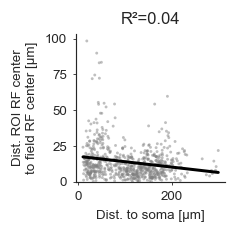

In [17]:
import scipy.stats

df_rois['rf_roi_dist'] = df_rois.apply(
    lambda r: (r['rf_dx_wrt_field_rf_um'] ** 2 + r['rf_dy_wrt_field_rf_um'] ** 2) ** 0.5, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.6))
sns.despine()

col_x = 'd_dist_to_soma'
col_y = 'rf_roi_dist'

not_null = df_rois[col_x].notnull() &  df_rois[col_y].notnull()
pearson_r = scipy.stats.pearsonr(df_rois[col_x][not_null], df_rois[col_y][not_null])

sns.regplot(ax=ax, data=df_rois, x=col_x, y=col_y, scatter_kws=dict(s=3, alpha=0.5, facecolor='gray', edgecolor='none'),
            line_kws=dict(color='k'), ci=None)
ax.set(title=f'R²={pearson_r.statistic ** 2.:.2f}',
       xlabel=f'Dist. to soma [µm]',
       ylabel=f'Dist. ROI RF center\nto field RF center [µm]')
ax.set_ylim(0, None)
plt.show()

## Field level

In [18]:
df_field_pos = paths_tab.fetch(format='frame').reset_index()

df_field_pos['soma_x'] = df_field_pos['soma_xyz'].apply(lambda x: x[0])
df_field_pos['soma_y'] = df_field_pos['soma_xyz'].apply(lambda x: x[1])
df_field_pos = df_field_pos.drop(['soma_xyz', 'experimenter', 'roi_pos_params_hash', 'stack'], axis=1)

df_field_pos['field_dx_wrt_soma'] = df_field_pos['field_path_pos_x'] - df_field_pos['soma_x']
df_field_pos['field_dy_wrt_soma'] = df_field_pos['field_path_pos_y'] - df_field_pos['soma_y']

df_field_pos['date'] = df_field_pos['date'].astype(str)
df_field_pos.set_index(['date', 'exp_num', 'field'], inplace=True)
roi_d_dists = roi_pos_tab.proj('d_dist_to_soma').fetch(format='frame').reset_index()
roi_d_dists['date'] = roi_d_dists['date'].astype(str)

df_field_pos['field_d_dist_to_soma'] = roi_d_dists.groupby(['date', 'exp_num', 'field'])['d_dist_to_soma'].median()

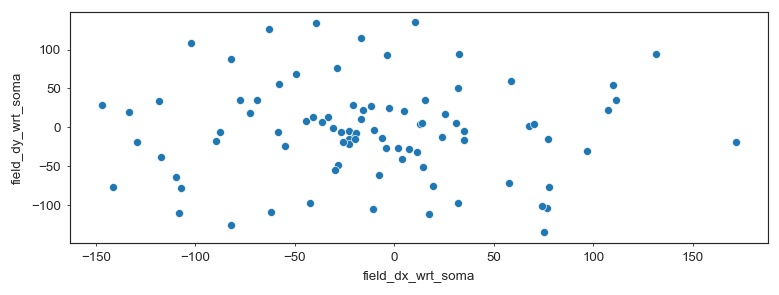

In [19]:
sns.scatterplot(data=df_field_pos, x='field_dx_wrt_soma', y='field_dy_wrt_soma');

In [20]:
df_fields = df_field_rfs.merge(df_field_pos, left_index=True, right_index=True, how='inner')

id_cols = [col for col in df_fields.columns if col.endswith('_id') and col != 'roi_id']
for col in id_cols:
    assert df_fields[col].nunique() == 1, (col, df_fields[col].unique())

df_fields = df_fields.drop(id_cols, axis=1)

df_fields['rf_dx_wrt_soma'] = df_fields['field_rf_dx_um'] + df_fields['field_dx_wrt_soma']
df_fields['rf_dy_wrt_soma'] = df_fields['field_rf_dy_um'] + df_fields['field_dy_wrt_soma']

df_fields['rf_dx_wrt_soma_corrected_field_rf_avg'] = (
            df_fields['rf_dx_wrt_soma'] - df_fields.groupby(['date', 'exp_num'])['rf_dx_wrt_soma'].median())
df_fields['rf_dy_wrt_soma_corrected_field_rf_avg'] = (
            df_fields['rf_dy_wrt_soma'] - df_fields.groupby(['date', 'exp_num'])['rf_dy_wrt_soma'].median())

In [21]:
def plot_field_level(axs, method='pearson', robust=False):
    for i, p in enumerate(['x', 'y']):
        ax = axs[i]

        col_x = f'field_d{p}_wrt_soma'
        col_y = f'rf_d{p}_wrt_soma'

        test = pg.corr(df_fields[col_x], df_fields[col_y], method=method)
        display(test)
        r_stat = test.loc[method, 'r']

        sns.regplot(ax=ax, data=df_fields, x=col_x, y=col_y,
                    scatter_kws=dict(s=4, alpha=0.5, fc='C0', ec='none'), line_kws=dict(color='k', zorder=-20),
                    ci=None, robust=robust)

        #ax.set_aspect('equal', 'datalim')
        vmin = np.max([df_fields[col_x].min(), df_fields[col_y].min()])
        vmax = np.min([df_fields[col_x].max(), df_fields[col_y].max()])

        ax.axhline(0, c='gray', alpha=0.7, zorder=-10, ls='--')
        ax.axvline(0, c='gray', alpha=0.7, zorder=-10, ls='--')
        ax.axline([vmin * 1.3, vmin * 1.3], [vmax * 1.3, vmax * 1.3], c='gray', alpha=0.7, zorder=-10, ls='--',
                  clip_on=True)

        ax.set(title=f'r²={r_stat ** 2:.2f}',
               xlabel=rf'$\Delta${p} ' + r'(Field, Soma)' + '\n[µm]',  #f'Field {p}-position\nw.r.t. to soma [µm]',
               ylabel=rf'$\Delta${p} ' + r'(RF$_\mathrm{Field}$, Soma)' + '\n[µm]')  #f'Field RF {p}-position\nw.r.t. to soma [µm]')

    for ax in axs:
        ax.set(xticks=(-100, 0, 100), yticks=(-100, 0, 100))

,n,r,CI95%,p-val,BF10,power
pearson,84,0.946529,"[0.92, 0.97]",4.781673e-42,2.888e+38,1.0


,n,r,CI95%,p-val,BF10,power
pearson,84,0.917667,"[0.88, 0.95]",1.294764e-34,1.662e+31,1.0


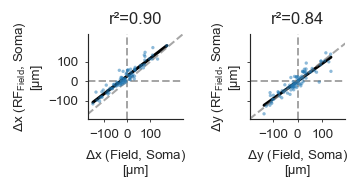

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(3, 1.6), sharey='row')
sns.despine()
plot_field_level(axs)
plt.tight_layout(w_pad=2, pad=1)
plt.show()

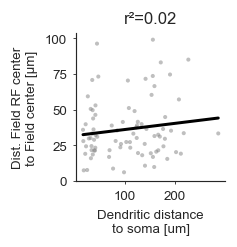

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.6))
sns.despine()

col_x = 'field_d_dist_to_soma'
col_y = 'field_rf_d_um'

not_null = df_fields[col_x].notnull() &  df_fields[col_y].notnull()
pearson_r = scipy.stats.pearsonr(df_fields[col_x][not_null], df_fields[col_y][not_null])

sns.regplot(ax=ax, data=df_fields, x=col_x, y=col_y,
            scatter_kws=dict(s=6, alpha=0.5, facecolor='gray', edgecolor='none'), line_kws=dict(color='k'), ci=None)
ax.set(title=f'r²={pearson_r.statistic ** 2.:.2f}',
       xlabel=f'Dendritic distance\nto soma [um]',
       ylabel=f'Dist. Field RF center\nto Field center [µm]')
ax.set_ylim(0, None)
plt.show()

## Merge field and ROI level

,n,r,CI95%,p-val,BF10,power
pearson,84,0.946529,"[0.92, 0.97]",4.781673e-42,2.888e+38,1.0


,n,r,CI95%,p-val,BF10,power
pearson,84,0.917667,"[0.88, 0.95]",1.294764e-34,1.662e+31,1.0


,n,r,CI95%,p-val,BF10,power
pearson,687,0.521304,"[0.46, 0.57]",3.932625e-49,5.164e+45,1.0


,n,r,CI95%,p-val,BF10,power
pearson,687,0.374254,"[0.31, 0.44]",2.892559e-24,1.148e+21,1.0


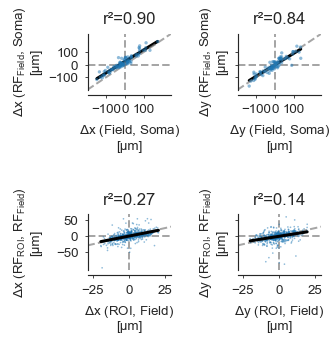

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(2.8, 2.9), sharey='row', sharex='row')
sns.despine()

plota.move_xaxis_outward(axs)
plot_field_level(axs[0, :])

plot_roi_level(axs[1, :])

fig.align_labels()
plt.tight_layout(w_pad=2, pad=1, h_pad=3)

fig.savefig(os.path.join(FIGURE_FOLDER, f'rf_localization_field_and_roi_level_{indicator}.pdf'), bbox_inches='tight')
plt.show()